# Learn actively, and listen carefully to small-text

In this tutorial, you will learn how to set up a complete active learning loop with a [Hugging Face transformer](https://huggingface.co/docs/transformers/index):

 - Use the excellent [small-text](https://github.com/webis-de/small-text) library to set up your active learner;
 - Use a [Rubrix listener](../reference/python/python_listeners.rst) to build and start an active learning loop;
 - Use the [Rubrix UI](../reference/webapp/annotate_records.md) to annotate examples and learn actively;

[Screenshot]

## Introduction

> Active learning is a special case of machine learning in which a learning algorithm can interactively query a user (or some other information source) to label new data points with the desired outputs. [Wikipedia](https://en.wikipedia.org/wiki/Active_learning_(machine_learning))

This tutorial will show you how to incorporate Rubrix into an active learning workflow involving a human in the loop. 
We will build a simple text classifier by combining the active learning framework small-text and Rubrix. 
Hugging Face's transformers will provide the classifier we will embed in an active learner from small-text. 
You and Rubrix will be the information source that teaches the model to become a sample-efficient classifier.

## Setup

Rubrix is a free and open-source tool to explore, annotate, and monitor data for NLP projects.

If you are new to Rubrix, check out the [Github repository](https://github.com/recognai/rubrix) ⭐.

If you have not installed and launched Rubrix yet, check the [Setup and Installation Guide](https://rubrix.readthedocs.io/en/master/getting_started/setup%26installation.html).

For this tutorial, we also need some third-party libraries that you can install via pip:

In [ ]:
%pip install datasets "small-text" "transformers[torch]"

## The TREC dataset

For this tutorial, we will use the well-known [TREC dataset](https://huggingface.co/datasets/trec) containing 6000 labeled questions; 5500 in the training and 500 in the test split. 
This dataset can be turned into a text classification task, in which a model must predict one of the six coarse labels given the question. 
The labels consist of ABBREVIATION (ABBR), ENTITY (ENTY), DESCRIPTION (DESC), HUMAN (HUM), LOCATION (LOC), and NUMERIC VALUE (NUM).

Let us load the dataset from the [Hugging Face Hub](https://huggingface.co/datasets):

In [ ]:
import datasets

trec = datasets.load_dataset('trec')

## Preprocessing the dataset

We first need to wrap the dataset in a specific data class provided by [small-text](https://github.com/webis-de/small-text), the excellent active learning framework we will use in this tutorial. 
Since we will choose a [Hugging Face transformer](https://huggingface.co/docs/transformers/index) in the active learner, small-text will expect a `TransformersDataset` object that already contains the tokenized input text.

So, let's tokenize our data with the tokenizer corresponding to the transformer model we will choose.

In [ ]:
from transformers import AutoTokenizer

# Choose transformer model
TRANSFORMER_MODEL = "google/electra-small-discriminator"

# Init tokenizer
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL)

# Helper function to tokenize the input text
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=64, truncation=True)

# Tokenize dataset
trec_tokenized = trec.map(tokenize, batched=True, remove_columns=["text"])

After tokenizing the input text, we can create the dataset for small-text.
It expects a tuple of [PyTorch tensors](https://pytorch.org/docs/stable/tensors.html) containing the `inputs_ids`, the `attention_mask`, and a label if available.

In [29]:
from small_text.integrations.transformers import TransformersDataset
from small_text.base import LABEL_UNLABELED

# Set convenient output format 
trec_tokenized.set_format("torch")

# Create tuples from the tokenized training data
data = [
    # Need to add an extra dimension to indicate a batch size of 1 -> [None]
    (row["input_ids"][None], row["attention_mask"][None], LABEL_UNLABELED) 
    for row in trec_tokenized["train"]
]

# Create the dataset for small-text
dataset = TransformersDataset(data)

We will also create a test dataset to track the performance of the transformer model during the active learning loop.

In [4]:
# Create test dataset
data_test = [
    (row["input_ids"][None], row["attention_mask"][None], int(row["label-coarse"])) 
    for row in trec_tokenized["test"]
]
dataset_test = TransformersDataset(data_test)

## Setting up the active learner

Now that we have our datasets ready let's set up the active learner. 
For this, we need two components:

 - the classifier;
 - the query strategy;
 
In our case, we choose a [Hugging Face transformer](https://huggingface.co/docs/transformers/index) as the classifier and a [tie-breaker](https://small-text.readthedocs.io/en/v1.0.0/components/query_strategies.html#small_text.query_strategies.strategies.BreakingTies) as the query strategy. 
The latter selects instances of the data pool with a small margin between the two most likely predicted labels. 

In [5]:
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.integrations.transformers import TransformerModelArguments
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = TransformerBasedClassificationFactory(
    TransformerModelArguments(TRANSFORMER_MODEL),
    num_classes=6,
    # If you have a cuda device, specify it here.
    # Otherwise, just remove the following line.
    kwargs={"device": "cuda"}
)

# Define our query strategy
query_strategy = BreakingTies()

# Use the active learner with a pool containing all unlabeled data 
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

We randomly draw a subset from the data pool as the initialization strategy. 
After obtaining the labels for this batch of instances, the active learner will use them to create the first classifier.

In [6]:
from small_text.initialization import random_initialization
import numpy as np
# Fix seed for reproducibility 
np.random.seed(42)


# Number of samples in our queried batches
NUM_SAMPLES = 20

# Randomly draw an initial subset from the data pool
initial_indices = random_initialization(dataset, NUM_SAMPLES)

## Rubrix and you: the perfect oracle

With our active learner ready, it is time to teach it. 
We first create a [Rubrix dataset](../reference/webapp/dataset.md) to log and label the initial random batch queried by the active learner.

In [ ]:
import rubrix as rb


# Choose a name for the dataset
DATASET_NAME = "trec_with_active_learning"

# Define labeling schema
labels = trec["train"].features["label-coarse"].names
settings = rb.TextClassificationSettings(label_schema=labels)

# Create dataset with a label schema
rb.configure_dataset(name=DATASET_NAME, settings=settings)

# Create records from the initial batch
records = [
    rb.TextClassificationRecord(
        text=trec["train"]["text"][idx], 
        metadata={"batch_id": 0},
        id=idx,
    )
    for idx in initial_indices
]

# Log initial records to Rubrix
rb.log(records, DATASET_NAME)

Before switching to the Rubrix UI to label the records, we will set up the **active learning loop**. 
For this, we will use the [listener decorator](../reference/python/rubrix_listener.rst#rubrix.listeners.listener) from Rubrix. 
The loop will run automatically once all records of a batch are labeled (see the `query` and `condition` argument of the decorator). 
It will trigger the classifier's training, query a new batch from the active learner and log it to Rubrix. 
We will also keep track of the accuracy of the current classifier by evaluating it on our test set.

In [9]:
from rubrix.listeners import listener
from sklearn.metrics import accuracy_score

# Define some helper variables
LABEL2INT = trec["train"].features["label-coarse"].str2int
ACCURACIES = []

# Set up the active learning loop with the listener decorator
@listener(
    dataset=DATASET_NAME,
    query="status:Validated AND metadata.batch_id:{batch_id}",
    condition=lambda search: search.total==NUM_SAMPLES,
    execution_interval_in_seconds=3,
    batch_id=0
)
def active_learning_loop(records, ctx):
    
    # 1. Update active learner
    print(f"Updating with batch_id {ctx.query_params['batch_id']} ...") 
    y = np.array([LABEL2INT(rec.annotation) for rec in records])
    
    # initial update
    if ctx.query_params["batch_id"] == 0:
        indices = np.array([rec.id for rec in records])
        active_learner.initialize_data(indices, y)
    # update with the prior queried indices
    else:
        active_learner.update(y)
    print("Done!")
        
    # 2. Query active learner
    print("Querying new data points ...")
    queried_indices = active_learner.query(num_samples=NUM_SAMPLES)
    ctx.query_params["batch_id"] += 1
    new_records = [
        rb.TextClassificationRecord(
            text=trec["train"]["text"][idx], 
            metadata={"batch_id": ctx.query_params["batch_id"]},
            id=idx,
        ) 
        for idx in queried_indices
    ]
          
    # 3. Log the batch to Rubrix
    rb.log(new_records, DATASET_NAME)    
    
    # 4. Evaluate current classifier on the test set
    print("Evaluating current classifier ...")
    accuracy = accuracy_score(
        dataset_test.y, 
        active_learner.classifier.predict(dataset_test),
    )
    ACCURACIES.append(accuracy)
    print("Done!")
    
    print("Waiting for annotations ...")

## Starting the active learning loop

Now we can start the loop and switch to the Rubrix UI.

In [ ]:
active_learning_loop.start()

In the Rubrix UI, we will set the number of records per page to 20 since it is also our chosen batch size. 
Furthermore, we will use the [Status filter](../reference/webapp/filter_records.md) to filter out already annotated records. 
Now, all we have to do is to annotate the displayed records. 
Once annotating everything, the classifier's training will be automatically triggered.

After a few seconds, you should see the newly queried batch when pressing the [Refresh button](../reference/webapp/dataset.md#refresh). 
The training can take longer depending on your machine and whether you have a CUDA device. 
You can always check the status of the active learning loop from your notebook.

[Video]

## Can we stop?

After a few iterations, we can check the accuracy of the current classifier and plot its evaluation.

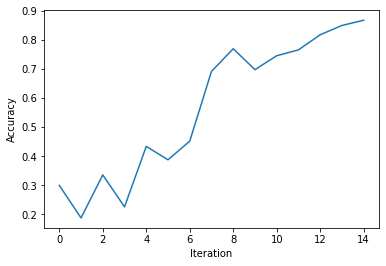

In [28]:
import pandas as pd

pd.Series(ACCURACIES).plot(xlabel="Iteration", ylabel="Accuracy");

We should achieve an accuracy of at least **0.8 after around 12 iterations**, corresponding to roughly 260 annotated records. 
The stopping criterium is ultimately up to you, and you can choose more sophisticated criteria like the [KappaAverage](https://small-text.readthedocs.io/en/v1.0.0/components/stopping_criteria.html) implemented in small-text.

In [11]:
active_learning_loop.stop()

## Summary

In this tutorial, we saw how you could **embed Rubrix in an active learning loop involving a human in the loop**. 
We relied on **small-text to use a Hugging Face transformer as an active learner** and gathered a **sample-efficient data set by annotating only the most decisive records**.

Rubrix makes it very easy to use a dedicated annotation team or subject matter experts as an oracle for your active learning system. They will only interact with the Rubrix UI and do not have to worry about training or querying the system. We encourage you to try out active learning in your next project and make your and your annotator's life a little easier.

## Next steps

⭐ [Rubrix Github repo](https://github.com/recognai/rubrix) to stay updated.

📚 [Rubrix documentation](https://rubrix.readthedocs.io/en/stable/index.html) for more guides and tutorials.

🙋‍♀️ Join the Rubrix community! A good place to start is our [slack channel](https://join.slack.com/t/rubrixworkspace/shared_invite/zt-whigkyjn-a3IUJLD7gDbTZ0rKlvcJ5g).


## Appendix: Simulation

In [18]:
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.integrations.transformers import TransformerModelArguments
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = TransformerBasedClassificationFactory(
    TransformerModelArguments(TRANSFORMER_MODEL),
    num_classes=6,
    # If you have a cuda device, specify it here.
    # Otherwise, just remove the following line.
    kwargs={"device": "cuda"}
)

# Define our query strategy
query_strategy = BreakingTies()

# Use the active learner with a pool containing all unlabeled data 
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

In [19]:
from small_text.initialization import random_initialization
import numpy as np

np.random.seed(42)
y = np.array(trec["train"]["label-coarse"])
initial_indices = random_initialization(dataset, n_samples=20)
active_learner.initialize_data(initial_indices, y[initial_indices])

In [20]:
from sklearn.metrics import accuracy_score

predictions = active_learner.classifier.predict(dataset_test)
accuracy_score(dataset_test.y, predictions)

0.3

In [21]:
accuracies = []

for i in range(15):
    print(f"Iteration: {i}", len(active_learner.indices_labeled))
    
    predictions = active_learner.classifier.predict(dataset_test)
    accuracies.append(accuracy_score(dataset_test.y, predictions))
    
    indices_queried = active_learner.query(num_samples=20)
    y = trec_tokenized["train"]["label-coarse"][indices_queried].numpy()
    active_learner.update(y)

Iteration: 0 20
Iteration: 1 40
Iteration: 2 60
Iteration: 3 80
Iteration: 4 100
Iteration: 5 120
Iteration: 6 140
Iteration: 7 160
Iteration: 8 180
Iteration: 9 200
Iteration: 10 220
Iteration: 11 240
Iteration: 12 260
Iteration: 13 280
Iteration: 14 300


In [24]:
list(enumerate(accuracies))

[(0, 0.3),
 (1, 0.188),
 (2, 0.336),
 (3, 0.226),
 (4, 0.434),
 (5, 0.388),
 (6, 0.452),
 (7, 0.692),
 (8, 0.77),
 (9, 0.698),
 (10, 0.746),
 (11, 0.766),
 (12, 0.818),
 (13, 0.85),
 (14, 0.868)]

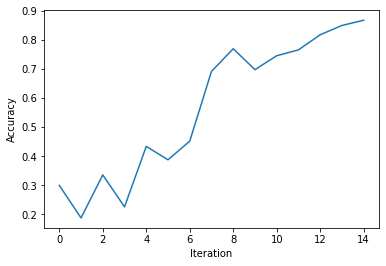

In [28]:
import pandas as pd

pd.Series(accuracies).plot(xlabel="Iteration", ylabel="Accuracy");

In [34]:
idx = active_learner.indices_labeled
pd.Series(trec_tokenized["train"]["label-coarse"][idx]).value_counts()

1    104
3     86
5     84
0     73
4     66
2      7
dtype: int64

In [38]:
from sklearn.metrics import classification_report

print(classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test)))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82       138
           1       0.83      0.80      0.82        94
           2       0.00      0.00      0.00         9
           3       0.87      0.94      0.90        65
           4       0.98      0.51      0.67       113
           5       0.81      0.98      0.88        81

    accuracy                           0.81       500
   macro avg       0.70      0.70      0.68       500
weighted avg       0.82      0.81      0.79       500



/home/david/miniconda3/envs/rubrix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/miniconda3/envs/rubrix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/miniconda3/envs/rubrix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# With sklearn

## Preprocess data

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Extract the text features
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(trec["train"]["text"])

In [14]:
import numpy as np
from small_text.base import LABEL_UNLABELED
from small_text.data import SklearnDataset


# Create a dataset for small-text
dataset = SklearnDataset(text_features, np.array([LABEL_UNLABELED]*len(trec["train"])))

In [15]:
# Create test dataset
dataset_test = SklearnDataset(
    vectorizer.transform(trec["test"]["text"]),
    np.array(trec["test"]["label-coarse"]),
)

## Set up Active Learner

In [16]:
from small_text.classifiers import ConfidenceEnhancedLinearSVC
from small_text.classifiers.factories import SklearnClassifierFactory
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = SklearnClassifierFactory(
    base_estimator=ConfidenceEnhancedLinearSVC(), 
    num_classes=6
)

# Define our query strategy
query_strategy = BreakingTies()

# Use the active learner with a pool-based sampling 
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

## Simulation

In [19]:
from small_text.classifiers import ConfidenceEnhancedLinearSVC
from small_text.classifiers.factories import SklearnClassifierFactory
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner

clf_factory = SklearnClassifierFactory(
    base_estimator=ConfidenceEnhancedLinearSVC(), 
    num_classes=6
)
query_strategy = BreakingTies()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

In [20]:
from small_text.initialization import random_initialization
import numpy as np

np.random.seed(42)
y = np.array(trec["train"]["label-coarse"])
initial_indices = random_initialization(dataset, n_samples=20)
active_learner.initialize_data(initial_indices, y[initial_indices])

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
accuracies = []

for _ in range(20):
    acc = classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test), output_dict=True)["accuracy"]
    accuracies.append(acc)
    
    idx = active_learner.query(num_samples=20)
    active_learner.update(y[idx])
    
acc = classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test), output_dict=True)["accuracy"]
accuracies.append(acc)

<AxesSubplot:>

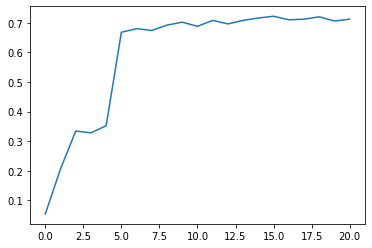

In [22]:
pd.Series(accuracies).plot()

In [22]:
accuracies[19]

0.706